## 6.6 Sourcing & Analyzing Time-Series Data

In [51]:
# Import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings

In [52]:
# Set path
path=r'C:\Users\User\Downloads\Achievement 6'

In [53]:
# Import data set
df=pd.read_csv(os.path.join(path, 'Data', 'flavors_of_cacao_cleaned.csv'))

In [6]:
df.head()

,Unnamed: 0,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Broad Bean Origin
0,0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,Sao Tome
1,1,A. Morin,Kpime,1676,2015,70.0,France,2.75,Togo
2,2,A. Morin,Atsane,1676,2015,70.0,France,3.00,Togo
3,3,A. Morin,Akata,1680,2015,70.0,France,3.50,Togo
4,4,A. Morin,Quilla,1704,2015,70.0,France,3.50,Peru


In [54]:
# Creating a subset containing only "Review Date"  and "Rating" columns
df1=df[['Review Date', 'Rating']]

In [8]:
df1.head()

,Review Date,Rating
0,2016,3.75
1,2015,2.75
2,2015,3.00
3,2015,3.50
4,2015,3.50


In [9]:
df1.shape

(1794, 2)

In [10]:
df1.columns

Index(['Review Date', 'Rating'], dtype='object')

In [11]:
# Set 'Review Date' as index
df1.set_index('Review Date', inplace=True)


In [12]:
df1.columns

Index(['Rating'], dtype='object')

In [13]:
type(df1)

pandas.core.frame.DataFrame

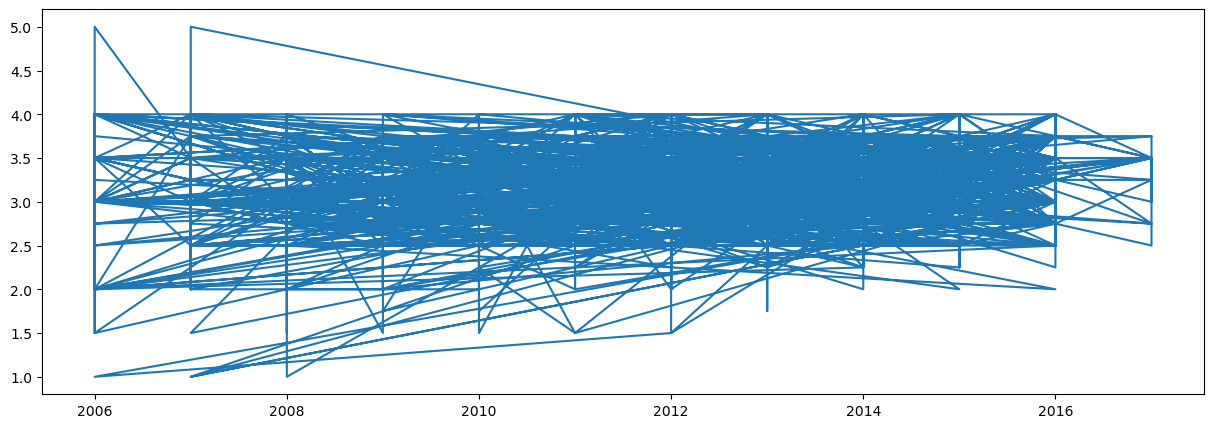

In [39]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(df1)

#### The x-axis is too cluttered because there are too many data points. To reduce the number of points, I will aggregate the data by year.


In [55]:
# Reset index
df2 = df1.reset_index()

In [56]:
# Aggregate data by year
df3 = df2.groupby(df2['Review Date']).mean()


In [17]:
df3.head()

,Rating
Review Date,
2006,3.125000
2007,3.162338
2008,2.994624
2009,3.073171
2010,3.148649


In [18]:
df3.shape

(12, 1)

In [19]:
df3.columns

Index(['Rating'], dtype='object')

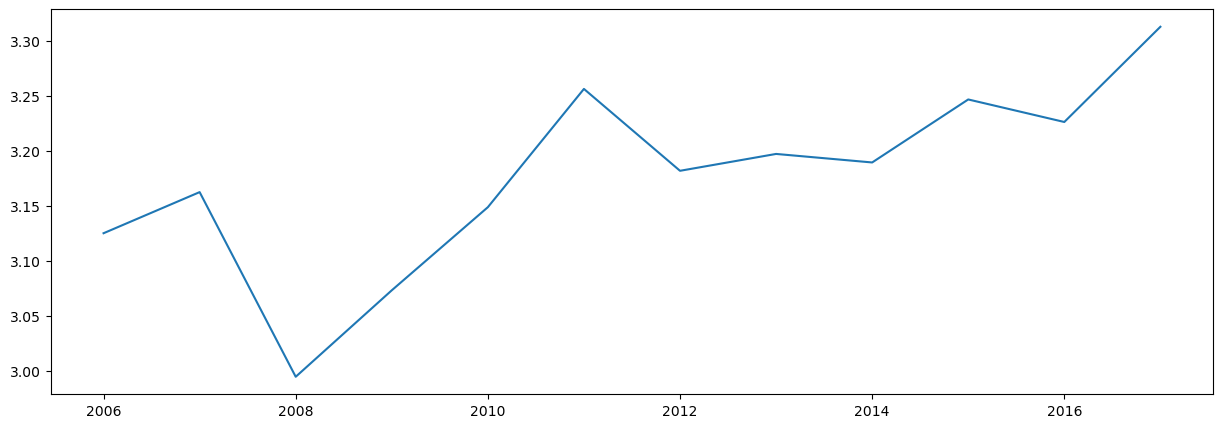

In [40]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(df3)

In [41]:
# Reset index so that I can use the "Date" column as a filter

df4 = df3.reset_index()

In [22]:
# Ensure the Date column is a datetime index
df4['Review Date'] = pd.to_datetime(df4['Review Date']) 
df4.set_index('Review Date', inplace=True)

In [23]:
# Ensure the time series column is numeric
df4['Rating'] = pd.to_numeric(df4['Rating'], errors='coerce')  

In [24]:
df4.head()

,Rating
Review Date,
1970-01-01 00:00:00.000002006,3.125000
1970-01-01 00:00:00.000002007,3.162338
1970-01-01 00:00:00.000002008,2.994624
1970-01-01 00:00:00.000002009,3.073171
1970-01-01 00:00:00.000002010,3.148649


In [25]:
df4.shape

(12, 1)

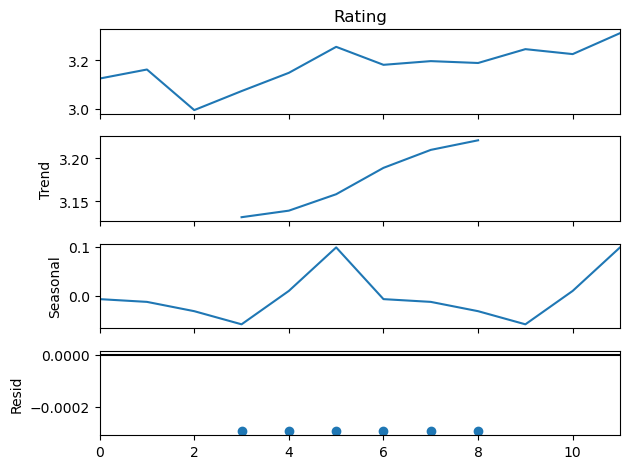

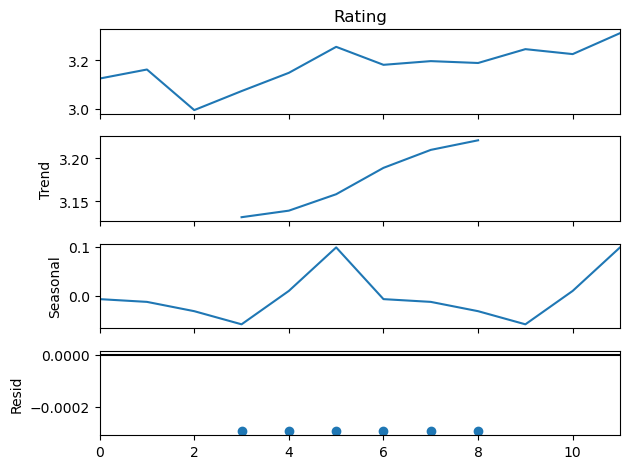

In [44]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df4['Rating'], model='additive', period=6)
decomposition.plot()

###  Trend Component:
#### The trend shows a steady increase in ratings over time.
### Seasonal Component:
#### The seasonal component captures repeating patterns within the data.
#### Since the data is yearly, the seasonality component is weak but does show some fluctuations.
### Residuals: 
#### The noises are very small (almost negligible), suggesting that most of the variation in the data is explained by the trend and seasonality components.



## Testing for stationarity

#### Null hypothesis: There is a unit root in the data, and the data is non-stationary.
#### Alternative hypothesis: there’s no unit root, the data is stationary.

In [48]:

from statsmodels.tsa.stattools import adfuller 
def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)
dickey_fuller(df4['Rating'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.265597
p-value                        0.644761
Number of Lags Used            3.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


#### Looking at the “Critical Value (5%)” in the results, which has a value of -3.367187. This is much smaller than the test statistic (-1.265597), which means that  the null hypothesis can not be rejected. There is a unit root in the data, and the data is non-stationary.

##  Stationarizing the data

In [49]:
#  Data differencing
data_diff = df4 - df4.shift(1)

In [50]:
# Remove the missing values that came about as a result of the differencing. 
data_diff.dropna(inplace = True) 

In [32]:
data_diff.head()

,Rating
Review Date,
1970-01-01 00:00:00.000002007,0.037338
1970-01-01 00:00:00.000002008,-0.167714
1970-01-01 00:00:00.000002009,0.078547
1970-01-01 00:00:00.000002010,0.075478
1970-01-01 00:00:00.000002011,0.107412


In [33]:
data_diff.columns

Index(['Rating'], dtype='object')

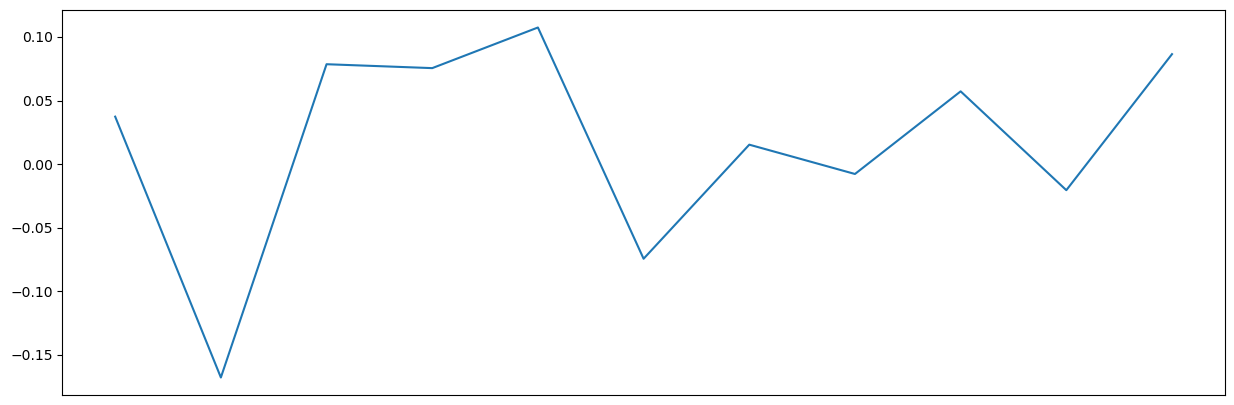

In [34]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [46]:
# Repeat Dickey-Fuller Stationarity test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -5.549723
p-value                        0.000002
Number of Lags Used            2.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


#### After applying data differencing, the **Test Statistic** is now lower than the **Critical Value (5%)**, indicating that the dataset has achieved stationarity. 

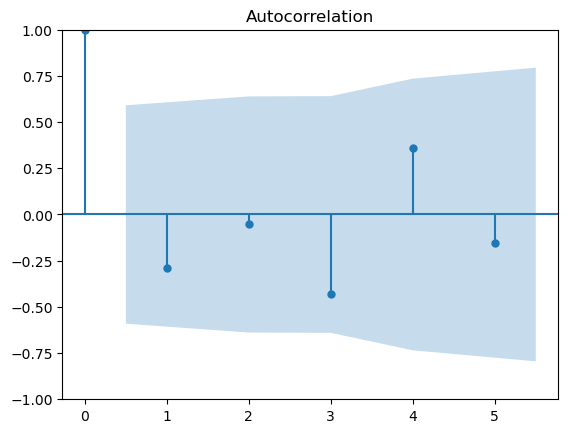

In [36]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_diff)
plt.show()

#### Most lags fall within the confidence interval, meaning there is no strong autocorrelation pattern. 